# Linear Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

## Load and Preprocess the Dataset

In [2]:
iris = load_iris(as_frame=True)
x = iris.data['petal length (cm)']
y = iris.data['petal width (cm)']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

## Create the Model from Scratch

In [3]:
class LinearRegressionFromScratch:
    LINE_PLOT_X_LIM = [-2, 8]
    LINE_PLOT_Y_LIM = [-3, 7]
    GRADIENT_PLOT_M_LIM = [-1, 2]
    GRADIENT_PLOT_B_LIM = [-3, 3]
    GRADIENT_PLOT_MSE_LIM = [0, 8]
    
    def __init__(self):
        self.x = None
        self.y = None
        self.n = None
        self.m = 1
        self.b = 0

    def predict(self, x_param, m_param=None, b_param=None):
        m = m_param if m_param else self.m
        b = b_param if b_param else self.b
        
        return m * x_param + b

    def get_partial_derivative_m(self, x_param, y_param):
        return -2 * (x_param * (y_param - self.predict(x_param)))
    
    def get_partial_derivative_b(self, x_param, y_param):
        return -2 * (y_param - self.predict(x_param))

    def get_mean_squared_error(self, m_param, b_param):            
        return np.sum((y - self.predict(self.x, m_param, b_param)) ** 2) / self.n

    def run_one_epoch(self, lr):
        self.m -= lr * (np.sum(self.get_partial_derivative_m(self.x, self.y)) / self.n)
        self.b -= lr * (np.sum(self.get_partial_derivative_b(self.x, self.y)) / self.n)

    def get_line_coordinates(self):
        line_coordinates_x = np.arange(self.LINE_PLOT_X_LIM[0], self.LINE_PLOT_X_LIM[1] + 1)
        line_coordinates_y = self.predict(line_coordinates_x)
            
        return line_coordinates_x, line_coordinates_y
    
    def animate_line_plot(self, frame, ax1, line_coordinates_x_frames, line_coordinates_y_frames):
        ax1.clear()
        ax1.set_xlim(self.LINE_PLOT_X_LIM)
        ax1.set_ylim(self.LINE_PLOT_Y_LIM)
        ax1.axhline(0, color='black')
        ax1.axvline(0, color='black')
        ax1.scatter(x, y, edgecolors='black')
        ax1.plot(line_coordinates_x_frames[frame], line_coordinates_y_frames[frame], color='red')
        ax1.set_axisbelow(True)
        ax1.grid(color='grey')
        ax1.set_title(f"Epoch: {frame + 1}")
        ax1.set_xlabel('petal length (cm)')
        ax1.set_ylabel('petal width (cm)')
        ax1.set_xticks(np.arange(self.LINE_PLOT_X_LIM[0], self.LINE_PLOT_X_LIM[1]))
        ax1.set_yticks(np.arange(self.LINE_PLOT_Y_LIM[0], self.LINE_PLOT_Y_LIM[1]))
    
    def create_mse_meshgrid(self):
        step = 0.1

        m_x, b_y = np.mgrid[
            self.GRADIENT_PLOT_M_LIM[0]:self.GRADIENT_PLOT_M_LIM[1]:step,
            self.GRADIENT_PLOT_B_LIM[0]:self.GRADIENT_PLOT_B_LIM[1]:step
        ]
        mse_z = np.vectorize(self.get_mean_squared_error)(m_x, b_y)
        mse_z = np.clip(mse_z, self.GRADIENT_PLOT_MSE_LIM[0], self.GRADIENT_PLOT_MSE_LIM[1])
    
        return m_x, b_y, mse_z
    
    def animate_gradient_plot(self, frame, ax2,  m_frames, b_frames, mse_frames, title_frames,
                              mse_meshgrid):
        ax2.clear()
        ax2.view_init(azim=260 + (frame / 3), elev=30)
        ax2.set_xlim(self.GRADIENT_PLOT_M_LIM)
        ax2.set_ylim(self.GRADIENT_PLOT_B_LIM)
        ax2.set_zlim(self.GRADIENT_PLOT_MSE_LIM)
        ax2.plot_surface(mse_meshgrid[0], mse_meshgrid[1], mse_meshgrid[2], cmap=cm.coolwarm,
                         alpha=0.5)
        ax2.scatter(m_frames[frame], b_frames[frame], mse_frames[frame], color='red')
        ax2.set_title(title_frames[frame])
        ax2.set_xlabel('m parameter')
        ax2.set_ylabel('b parameter')
        ax2.set_zlabel('MSE')
        ax2.set_xticks(np.arange(self.GRADIENT_PLOT_M_LIM[0], self.GRADIENT_PLOT_M_LIM[1]))
        ax2.set_yticks(np.arange(self.GRADIENT_PLOT_B_LIM[0], self.GRADIENT_PLOT_B_LIM[1]))
        ax2.set_zticks(np.arange(self.GRADIENT_PLOT_MSE_LIM[0], self.GRADIENT_PLOT_MSE_LIM[1]))
    
    def animate(self, frame, ax1, ax2, line_coordinates_x_frames, line_coordinates_y_frames, 
                m_frames, b_frames, mse_frames, title_frames, mse_meshgrid):
        self.animate_line_plot(frame, ax1, line_coordinates_x_frames, line_coordinates_y_frames)
        self.animate_gradient_plot(frame, ax2,  m_frames, b_frames, mse_frames, title_frames, 
                                   mse_meshgrid)
    
    def fit(self, x_param, y_param, lr=0.01, epochs=1000, create_animation=False):
        if len(x_param.shape) != 1:
            raise Exception(("This linear regression implementation works only with "
                             "one-dimensional features!"))
        
        self.x = x_param
        self.y = y_param
        self.n = len(x_param)

        line_coordinates_x_frames = []
        line_coordinates_y_frames = []
        m_frames = []
        b_frames = []
        mse_frames = []
        title_frames = []
        
        for epoch in range(epochs):
            self.run_one_epoch(lr)

            if create_animation:
                line_coordinates_x, line_coordinates_y = self.get_line_coordinates()
                mse = self.get_mean_squared_error(self.m, self.b)
                
                line_coordinates_x_frames.append(line_coordinates_x)
                line_coordinates_y_frames.append(line_coordinates_y)
                m_frames.append(self.m)
                b_frames.append(self.b)
                mse_frames.append(mse)
                title_frames.append(f"MSE={mse:.5f} (m={self.m:2f}, b={self.b:2f})")
        
        if create_animation:
            mse_meshgrid = self.create_mse_meshgrid()

            fig = plt.figure(figsize=plt.figaspect(2.))
            ax1 = fig.add_subplot(2, 1, 1)
            ax2 = fig.add_subplot(2, 1, 2, projection='3d')
            animation = FuncAnimation(fig, self.animate, epochs, fargs=(
                ax1, ax2, line_coordinates_x_frames, line_coordinates_y_frames, 
                m_frames, b_frames, mse_frames, title_frames, mse_meshgrid
            ))

            fig.subplots_adjust(left=0.15, bottom=0.05, top=0.95, hspace=0.3)
            animation.save('linear_regression.gif', writer=PillowWriter(fps=20))

## Create an Animation

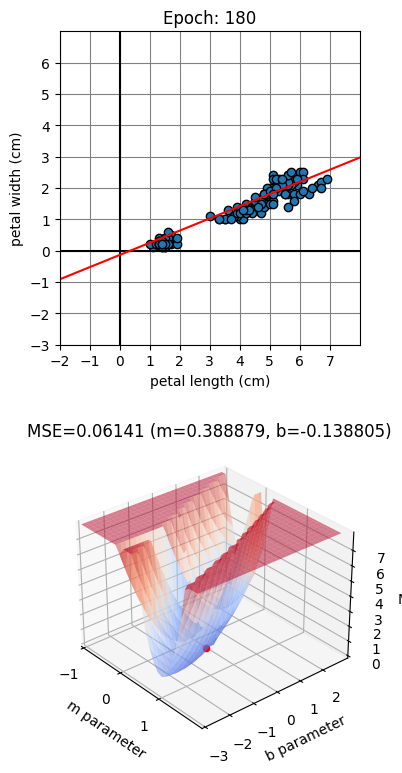

In [4]:
model_from_scratch = LinearRegressionFromScratch()

model_from_scratch.fit(x_train, y_train, lr=0.0005, epochs=180, create_animation=True)

## Compare Implementations

In [5]:
model_from_scratch = LinearRegressionFromScratch()

model_from_scratch.fit(x_train, y_train)

y_pred = model_from_scratch.predict(x_test)

mean_squared_error(y_test, y_pred)

0.03860633418249485

In [6]:
x_train = np.array(x_train).reshape(-1, 1)
x_test = np.array(x_test).reshape(-1, 1)

In [7]:
model = LinearRegression()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

mean_squared_error(y_test, y_pred)

0.03855843593099837